## Init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch import nn
import torch
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import RocCurveDisplay, auc
from sklearn import tree
from sklearn.preprocessing import StandardScaler


## Utils

In [3]:
import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve

def metrics_custom(y_real,y_pred):
  y_pred_rounded = [round(item) for item in y_pred]

  tn, fp, fn, tp = confusion_matrix(y_real, y_pred_rounded).ravel()
  # print("tn, fp, fn, tp = ",tn, fp, fn, tp)
  acc = (tp+tn) / (tp+tn+fp+fn)
  ppv = tp / (tp+fp)
  sen = tp / (tp+fn)
  spe = tn / (tn+fp)
  npv = tn / (tn+fn)
  f1 = (2*tp) / ((2*tp) + fp+fn)
  auc = metrics.roc_auc_score(y_real, y_pred)
  # print("acc: ",acc," ppv:",ppv," sen:",sen," spe:",spe," npv:",npv," f1:",f1,
        # " auc:",auc)
  return [acc,ppv,sen,spe,npv,f1,auc]


## Data exploration

In [5]:
# !pip install openpyxl

In [6]:
df  = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Workbook8.xlsx",sheet_name='Sheet1', engine='openpyxl')

In [7]:
print(df.info())
print("="*100)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Right                    66 non-null     float64
 1   Left                     67 non-null     float64
 2   Age                      133 non-null    float64
 3   Gender                   133 non-null    float64
 4   Followup                 133 non-null    float64
 5   lastfusize               115 non-null    float64
 6   regression               116 non-null    float64
 7   progression              116 non-null    float64
 8   stable                   116 non-null    float64
 9   Primary GK               101 non-null    float64
 10  Secondary GK             32 non-null     float64
 11  family history           133 non-null    float64
 12  Tumor size               133 non-null    float64
 13  Max dose                 128 non-null    float64
 14  Mean                     1

## Data pre-processing

In [8]:
def transform(df):
    df['right_left'] = df['Right'].combine_first(df['Left']) #Combine right and Left columns
    df['pri_sec_gk'] = df['Primary GK'].combine_first(df['Secondary GK']) #Combine Primary GK and Secondary GK columns
    df = df.drop(['Right', 'Left','lastfusize', 'Primary GK',
                  'Secondary GK','Total worsened Hearing ', 'Followup', 'Hearing post'], axis=1) #Remove unwanted columns


    df = df.dropna(subset=['Serviceable preserv'])
    df['regression'].fillna(0,inplace=True)
    df['progression'].fillna(0,inplace=True)
    df['stable'].fillna(0,inplace=True)
    df['Max dose'].fillna(24,inplace=True) #24 df['Max dose'].mean()
    df['Mean'].fillna(12,inplace=True) #12 df['Mean'].mean()
    return df

df  = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Workbook8.xlsx",sheet_name='Sheet1', engine='openpyxl')
df = transform(df)

In [9]:
Y = df['Serviceable preserv']
X = df.drop(['Serviceable preserv'], axis = 1)

In [10]:
Y.describe()

count    120.000000
mean       0.208333
std        0.407819
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Serviceable preserv, dtype: float64

In [11]:
X.describe()

,Age,Gender,regression,progression,stable,family history,Tumor size,Max dose,Mean,Associated tumors,Phenotype,Hearing pre,right_left,pri_sec_gk
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,28.466667,0.366667,0.433333,0.191667,0.250000,0.100000,4.292142,24.299342,16.068175,0.500000,0.266667,2.833333,0.516667,0.258333
std,12.073259,0.483915,0.497613,0.395263,0.434828,0.301258,4.441339,4.347157,2.961009,0.502096,0.444071,1.063792,0.501817,0.439554
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160000,0.098000,0.066000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.502500,24.000000,15.600000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.700000,24.200000,16.150000,0.500000,0.000000,3.000000,1.000000,0.000000
75%,34.000000,1.000000,1.000000,0.000000,0.250000,0.000000,5.602500,24.500000,16.725000,1.000000,1.000000,4.000000,1.000000,1.000000
max,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.360000,32.100000,21.100000,1.000000,1.000000,4.000000,1.000000,1.000000


In [12]:
print("Ground truth class counts: \n", Y.value_counts())
print("0.0 = Cannot hear (Above threshold)")
print("1.0 = Can hear (below threshold)")

Ground truth class counts: 
 0.0    95
1.0    25
Name: Serviceable preserv, dtype: int64
0.0 = Cannot hear (Above threshold)
1.0 = Can hear (below threshold)


## Data split and SMOTE

In [13]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=4)


sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5,9,10,12,13])
X_res, Y_res = sm.fit_resample(X_train, y_train)


print("Ground truth class counts before smote: \n", y_train.value_counts())
print("0.0 = Cannot hear (Above threshold)")
print("1.0 = Can hear (below threshold)")


print("Ground truth class counts after smote: \n", Y_res.value_counts())
print("0.0 = Cannot hear (Above threshold)")
print("1.0 = Can hear (below threshold)")


Ground truth class counts before smote: 
 0.0    69
1.0    15
Name: Serviceable preserv, dtype: int64
0.0 = Cannot hear (Above threshold)
1.0 = Can hear (below threshold)
Ground truth class counts after smote: 
 0.0    69
1.0    69
Name: Serviceable preserv, dtype: int64
0.0 = Cannot hear (Above threshold)
1.0 = Can hear (below threshold)


In [14]:
if True: #If sampled data should be used?
  X_train, y_train = X_res, Y_res

## Feature selection

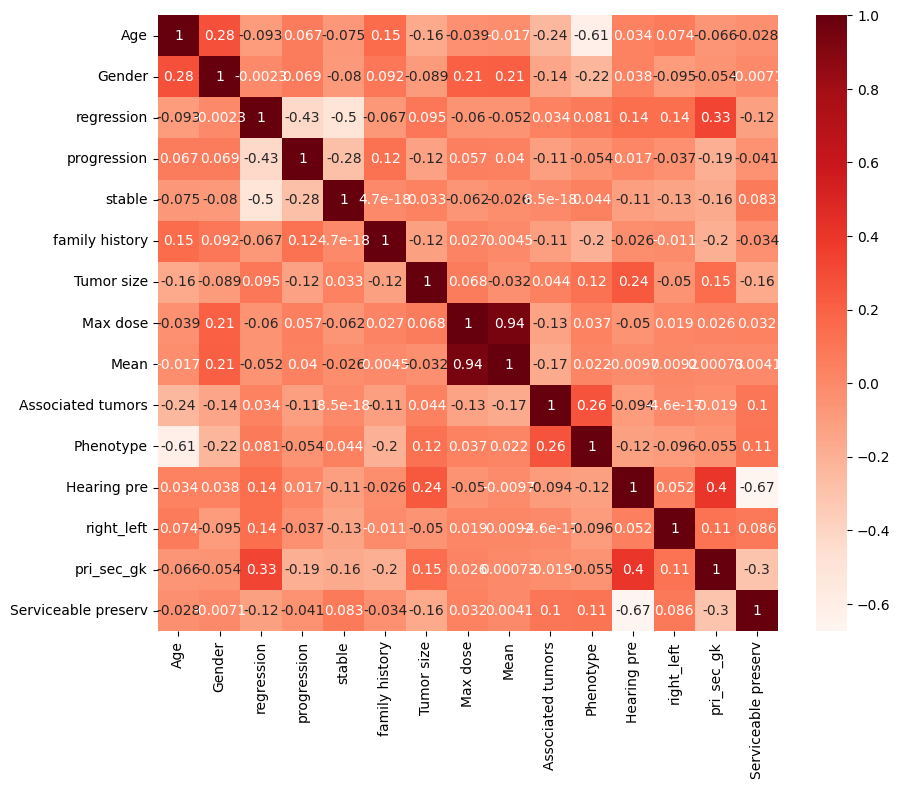

In [15]:
import seaborn as sns

plt.figure(figsize=(10,8))
full_df = X.copy()
full_df["Serviceable preserv"] = Y
cor = full_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#Question/observation: Mean and max doze has high coorelation
# Mean has very low coorelation with serveciable presev. Can it be removed?

In [16]:
# import statsmodels.api as sm
# print(Y.shape)
# print(X.shape)
# mod = sm.OLS(Y,X)
# fii = mod.fit()
# p_values = fii.summary2().tables[1]['P>|t|']
# fii.summary2()

In [17]:
#recursive feature elemination

# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(class_weight='balanced', solver = 'lbfgs', max_iter=1000)
# lr.fit(X_train,y_train)

# rfe = RFE(lr, n_features_to_select=1)
# rfe.fit(X_train,y_train)
# y_pred = rfe.predict(X_train)
# print(rfe.support_)
# print(rfe.ranking_)
# print(rfe.feature_names_in_)


In [18]:
# for count in range(len(names)):
#   X_subset = X.copy(deep=True)
#   # print()
#   X_subset = X_subset[names[:count+1]]
#   kf = KFold(n_splits=3, shuffle = True, random_state = 42)
#   kf.get_n_splits(X_subset)

#   res = []
#   for i, (train_index, test_index) in enumerate(kf.split(X_subset)):
#       # print("K-fold split",i,"="*50)
#       reg = LogisticRegression(solver='lbfgs', max_iter=1000)
#       reg.fit(X_subset.iloc[train_index], GT.iloc[train_index])
#       y_pred = reg.predict(X_subset.iloc[test_index])
#       # y_result = [1 if x<3 else 0 for x in y_pred]

#       # y_pred_scaled = 1-minmax_scale(y_pred)
#       # fpr, tpr, _ = metrics.roc_curve(GT.iloc[test_index], y_pred_scaled)
#       # auc = metrics.roc_auc_score(GT.iloc[test_index], y_pred_scaled)
#       # plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#       # plt.legend(loc=4)
#       # plt.show()

#       res.append(metrics_custom(GT.iloc[test_index],y_pred))
#       # print(confusion_matrix(GT.iloc[test_index], y_pred))
#       # print(classification_report(GT.iloc[test_index], y_pred))

#       res = pd.Series(reg.coef_[0], index = reg.feature_names_in_)
#       res.sort_values()

#   avg = np.array(res).mean(0)
#   print("="*100)
#   print(X_subset.columns)
#   print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
#   print(res.sort_values())
#   print("="*100)

family history       0.006001
right_left           0.012413
regression           0.013849
stable               0.021847
Associated tumors    0.025975
progression          0.027450
Gender               0.034014
pri_sec_gk           0.042315
Phenotype            0.054189
Max dose             0.056418
Tumor size           0.078653
Age                  0.093173
Mean                 0.095483
Hearing pre          0.438219
dtype: float64


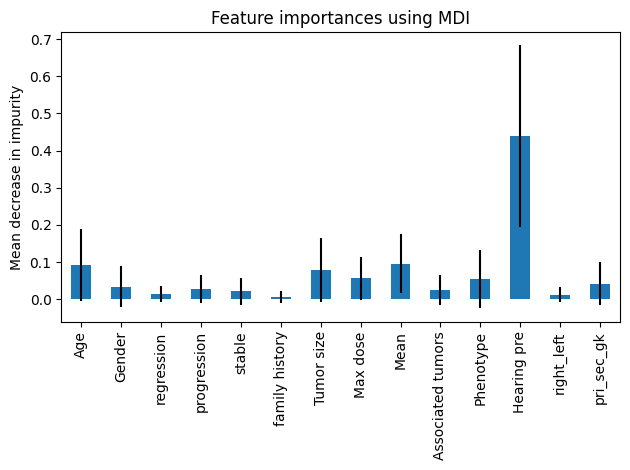

In [19]:
#Random forest for feature importance
from sklearn.ensemble import RandomForestClassifier

rfe = RandomForestClassifier(random_state=0)
rfe.fit(X_train,y_train)

imp = rfe.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfe.estimators_], axis=0)
# elapsed_time = time.time() - start_time

# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(imp, index=X.columns)

print(forest_importances.sort_values())
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [20]:
#Logistic regression for feature importance
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000)
lr.fit(X_train,y_train)
print(lr.coef_)

print(pd.Series(lr.coef_[0], index = lr.feature_names_in_))
res = pd.Series(map(abs, lr.coef_[0]), index = lr.feature_names_in_)
res.sort_values()

[[-1.01425704e-03 -6.31090571e-01 -4.71245132e-01 -8.66496060e-01
  -1.03452917e+00 -5.03333371e-01  7.82031960e-02  3.36188994e-01
  -2.91257746e-01 -1.14128690e-01  7.61994932e-01 -2.15616131e+00
   6.11850101e-01 -1.20295000e+00]]
Age                 -0.001014
Gender              -0.631091
regression          -0.471245
progression         -0.866496
stable              -1.034529
family history      -0.503333
Tumor size           0.078203
Max dose             0.336189
Mean                -0.291258
Associated tumors   -0.114129
Phenotype            0.761995
Hearing pre         -2.156161
right_left           0.611850
pri_sec_gk          -1.202950
dtype: float64


Age                  0.001014
Tumor size           0.078203
Associated tumors    0.114129
Mean                 0.291258
Max dose             0.336189
regression           0.471245
family history       0.503333
right_left           0.611850
Gender               0.631091
Phenotype            0.761995
progression          0.866496
stable               1.034529
pri_sec_gk           1.202950
Hearing pre          2.156161
dtype: float64

## Metrics

In [21]:
import sklearn
def test_model(ground_truth, predicted, print_roc=False):
    fpr, tpr, _ = sklearn.metrics.roc_curve(ground_truth, predicted)
    auc_val = sklearn.metrics.roc_auc_score(ground_truth, predicted)
    metrics = metrics_custom(ground_truth, predicted)

    print(confusion_matrix(ground_truth, predicted))
    print(classification_report(ground_truth, predicted))


    if print_roc:
      plt.plot(fpr,tpr,label="auc="+str(auc_val))
      plt.legend(loc=4)
      plt.show()


    return metrics, fpr, tpr, auc_val

## Logistic regression

In [22]:
#LR Model

def train_lr(features, results):
  # if index == None:
  #   index = features.index
  model = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000 )
  model.fit(features, results)
  return model

K-fold split 0 ==================================================
[[11  3]
 [ 1 13]]
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        14
         1.0       0.81      0.93      0.87        14

    accuracy                           0.86        28
   macro avg       0.86      0.86      0.86        28
weighted avg       0.86      0.86      0.86        28

K-fold split 1 ==================================================
[[15  1]
 [ 1 11]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        16
         1.0       0.92      0.92      0.92        12

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28

K-fold split 2 ==================================================
[[16  1]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0       0.94      0.94   

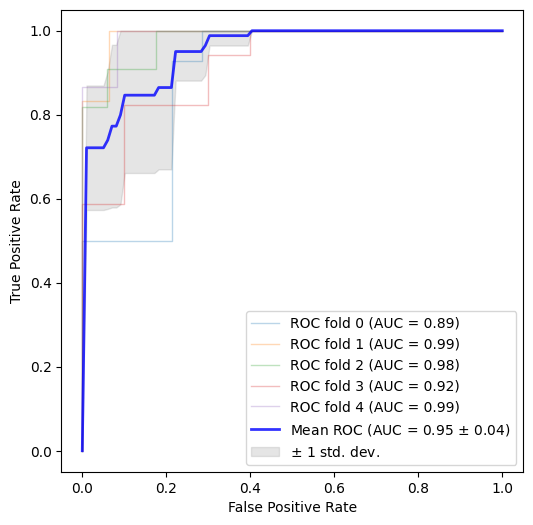

In [23]:
from sklearn.metrics import RocCurveDisplay, auc
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
kf.get_n_splits(X_train)

res = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print("K-fold split",i,"="*50)
    reg = train_lr(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = reg.predict(X_train.iloc[test_index])

    metrics1, fpr, tpr, auc_val = test_model(y_train.iloc[test_index], y_pred)
    # fpr, tpr, _ = metrics.roc_curve(y_train.iloc[test_index], y_pred)
    # auc_val = metrics.roc_auc_score(y_train.iloc[test_index], y_pred)
    # plt.plot(fpr,tpr,label="auc="+str(auc_val))
    # plt.legend(loc=4)
    # plt.show()

    res.append(metrics1)

    viz = RocCurveDisplay.from_estimator(
        reg,
        X_train.iloc[test_index],
        y_train.iloc[test_index],
        name=f"ROC fold {i}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

avg = np.array(res).mean(0)
print("="*100)
print(X_train.columns)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
print("="*100)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

ax.axis("square")
ax.legend(loc="lower right")
plt.show()

## Neural network

In [24]:
#NN model


class vest_pred(nn.Module):
    def __init__(self):
        super(vest_pred, self).__init__()
        self.l1 = torch.nn.Linear(14,28)
        # self.l2 = torch.nn.Linear(64,128)
        # self.l2_1 = torch.nn.Linear(128,256)
        # self.l2_2 = torch.nn.Linear(256,128)
        # self.l3 = torch.nn.Linear(128,64)
        self.l4 = torch.nn.Linear(28,1)
        self.act = torch.nn.ReLU()
        self.final = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.l1(x))
        # x = self.act(self.l2(x))
        # x = self.act(self.l2_1(x))
        # x = self.act(self.l2_2(x))
        # x = self.act(self.l3(x))
        x = self.final(self.l4(x))
        return x

def df_to_tensor(df):
    device = 'cpu'
    return torch.from_numpy(df.values).float().to(device)

def train_nn(features, results):
  model  = vest_pred()
  optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=0.0001)
  criterion = nn.BCELoss()
  xt = df_to_tensor(features)
  yt = df_to_tensor(results)
  epochs = 400
  for _ in (bar := tqdm(range(epochs))):
    losses, accuracies = [], []
    for x,y in zip(xt,yt):
      optimizer.zero_grad()
      y = torch.unsqueeze(y, 0)
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      accuracies.append(round(pred.item())==y.item())

    bar.set_description("Epoch:"+str(_)+" | Loss: "+str(round(sum(losses)/len(losses),4))+
                        " | Train Accuracy: "+str(round(sum(accuracies)/len(accuracies),4)))
  return model

@torch.no_grad()
def test_nn(features, net):
  net.eval()
  y_pred_rounded = []
  y_pred = []
  for x in (bar := tqdm(df_to_tensor(features))):
    output = net(x)
    y_pred_rounded.append(round(output.item()))
    y_pred.append(output.item())
  return y_pred, y_pred_rounded

In [25]:
#K-fold + training
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
kf.get_n_splits(X)

res = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
  print("K-fold",i,"="*50)
  net = train_nn(X_train.iloc[train_index], y_train.iloc[train_index])
  y_pred, y_pred_rounded = test_nn(X_train.iloc[test_index], net)

  # print(y_pred_rounded)
  metrics1, fpr, tpr, auc_val = test_model(y_train.iloc[test_index], y_pred_rounded)
  res.append(metrics1)

avg = np.array(res).mean(0)
print("="*100)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
print("="*100)

K-fold 0 ==================================================


Epoch:399 | Loss: 0.2085 | Train Accuracy: 0.9062: 100%|██████████| 400/400 [00:20<00:00, 19.98it/s]
100%|██████████| 24/24 [00:00<00:00, 6185.53it/s]


[[ 7  7]
 [ 0 10]]
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        14
         1.0       0.59      1.00      0.74        10

    accuracy                           0.71        24
   macro avg       0.79      0.75      0.70        24
weighted avg       0.83      0.71      0.70        24

K-fold 1 ==================================================


Epoch:399 | Loss: 0.1387 | Train Accuracy: 0.9375: 100%|██████████| 400/400 [00:17<00:00, 23.21it/s]
100%|██████████| 24/24 [00:00<00:00, 8527.90it/s]


[[10  3]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80        13
         1.0       0.75      0.82      0.78        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24

K-fold 2 ==================================================


Epoch:399 | Loss: 0.2207 | Train Accuracy: 0.8542: 100%|██████████| 400/400 [00:18<00:00, 22.09it/s]
100%|██████████| 24/24 [00:00<00:00, 7669.00it/s]


[[12  4]
 [ 0  8]]
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        16
         1.0       0.67      1.00      0.80         8

    accuracy                           0.83        24
   macro avg       0.83      0.88      0.83        24
weighted avg       0.89      0.83      0.84        24

K-fold 3 ==================================================


Epoch:399 | Loss: 0.172 | Train Accuracy: 0.9271: 100%|██████████| 400/400 [00:18<00:00, 22.04it/s]
100%|██████████| 24/24 [00:00<00:00, 8364.21it/s]


[[ 5  9]
 [ 0 10]]
              precision    recall  f1-score   support

         0.0       1.00      0.36      0.53        14
         1.0       0.53      1.00      0.69        10

    accuracy                           0.62        24
   macro avg       0.76      0.68      0.61        24
weighted avg       0.80      0.62      0.59        24

K-fold 4 ==================================================


Epoch:399 | Loss: 0.2217 | Train Accuracy: 0.8646: 100%|██████████| 400/400 [00:17<00:00, 23.19it/s]
100%|██████████| 24/24 [00:00<00:00, 7527.35it/s]

[[ 6  6]
 [ 0 12]]
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.67      1.00      0.80        12

    accuracy                           0.75        24
   macro avg       0.83      0.75      0.73        24
weighted avg       0.83      0.75      0.73        24

Average acc,ppv,sen,spe,npv,f1,auc: 0.7416666666666667 0.6395768833849329 0.9636363636363636 0.5752747252747252 0.9666666666666668 0.7626009217613416 0.7694555444555444


## SVM

In [26]:
#SVM model

def train_svm(features, results):
  model = SVC(kernel='linear', probability=True)
  model.fit(features, results)
  return model

In [27]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=5, shuffle = True, random_state = 42)
kf.get_n_splits(X_train)

res = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
  print("K-fold split",i,"="*50)

  clf = train_svm(X_train.iloc[train_index], y_train.iloc[train_index])
  y_pred = clf.predict_proba(X_train.iloc[test_index])
  y_pred = [x[1] for x in y_pred.tolist()]
  y_pred_rounded = [round(item) for item in y_pred]
  metrics1, fpr, tpr, auc_val = test_model(y_train.iloc[test_index], y_pred_rounded)
  res.append(metrics1)

avg = np.array(res).mean(0)
print("="*100)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
print("="*100)

K-fold split 0 ==================================================
[[14  0]
 [ 3  7]]
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        14
         1.0       1.00      0.70      0.82        10

    accuracy                           0.88        24
   macro avg       0.91      0.85      0.86        24
weighted avg       0.90      0.88      0.87        24

K-fold split 1 ==================================================
[[10  3]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80        13
         1.0       0.75      0.82      0.78        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24

K-fold split 2 ==================================================
[[16  0]
 [ 1  7]]
              precision    recall  f1-score   support

         0.0       0.94      1.00   

# Decision Trees

In [28]:
#DT model

def train_dt(features, results):
  model = tree.DecisionTreeClassifier(max_depth=4)
  model.fit(features, results)
  return model

In [29]:
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
kf.get_n_splits(X_train)

res = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
  print("K-fold split",i,"="*50)
  clf = train_dt(X_train.iloc[train_index], y_train.iloc[train_index])
  y_pred = clf.predict_proba(X_train.iloc[test_index])
  y_pred = [x[1] for x in y_pred.tolist()]
  y_pred_rounded = [round(item) for item in y_pred]
  metrics1, fpr, tpr, auc_val = test_model(y_train.iloc[test_index], y_pred_rounded)
  res.append(metrics1)

avg = np.array(res).mean(0)
print("="*100)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
print("="*100)

K-fold split 0 ==================================================
[[14  0]
 [ 2  8]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        14
         1.0       1.00      0.80      0.89        10

    accuracy                           0.92        24
   macro avg       0.94      0.90      0.91        24
weighted avg       0.93      0.92      0.91        24

K-fold split 1 ==================================================
[[12  1]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        13
         1.0       0.90      0.82      0.86        11

    accuracy                           0.88        24
   macro avg       0.88      0.87      0.87        24
weighted avg       0.88      0.88      0.87        24

K-fold split 2 ==================================================
[[16  0]
 [ 2  6]]
              precision    recall  f1-score   support

         0.0       0.89      1.00   

# COMPARISON

LOGISTIC REGRESSION==================================================
[[25  2]
 [ 0  9]]
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        27
         1.0       0.82      1.00      0.90         9

    accuracy                           0.94        36
   macro avg       0.91      0.96      0.93        36
weighted avg       0.95      0.94      0.95        36

Average acc,ppv,sen,spe,npv,f1,auc: 0.9444444444444444 0.8181818181818182 1.0 0.9259259259259259 1.0 0.9 0.962962962962963
LOGISTIC REGRESSION PROBA==================================================
[[25  2]
 [ 5  4]]
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88        27
         1.0       0.67      0.44      0.53         9

    accuracy                           0.81        36
   macro avg       0.75      0.69      0.71        36
weighted avg       0.79      0.81      0.79        36

Average acc,ppv,sen,spe,npv,f1,auc: 0.8

Epoch:399 | Loss: 0.1965 | Train Accuracy: 0.8897: 100%|██████████| 400/400 [00:24<00:00, 16.36it/s]
100%|██████████| 36/36 [00:00<00:00, 7863.50it/s]


[[12 15]
 [ 3  6]]
              precision    recall  f1-score   support

         0.0       0.80      0.44      0.57        27
         1.0       0.29      0.67      0.40         9

    accuracy                           0.50        36
   macro avg       0.54      0.56      0.49        36
weighted avg       0.67      0.50      0.53        36

Average acc,ppv,sen,spe,npv,f1,auc: 0.5 0.2857142857142857 0.6666666666666666 0.4444444444444444 0.8 0.4 0.5555555555555555


SUPPORT VECTOR MACHINE ==================================================
[[25  2]
 [ 2  7]]
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        27
         1.0       0.78      0.78      0.78         9

    accuracy                           0.89        36
   macro avg       0.85      0.85      0.85        36
weighted avg       0.89      0.89      0.89        36

Average acc,ppv,sen,spe,npv,f1,auc: 0.8888888888888888 0.7777777777777778 0.7777777777777778 0.9259259259259

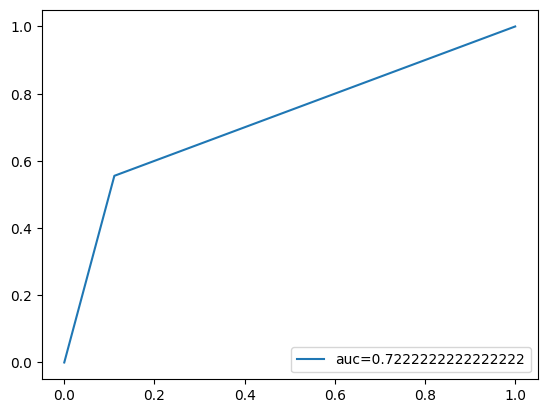

Average acc,ppv,sen,spe,npv,f1,auc: 0.8055555555555556 0.625 0.5555555555555556 0.8888888888888888 0.8571428571428571 0.5882352941176471 0.7222222222222222


In [30]:
#Model comparison

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=6)


sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5,9,10,12,13])
X_train, y_train = sm.fit_resample(X_train, y_train)


print("LOGISTIC REGRESSION"+"="*50)
lr = train_lr(X_train,y_train)
y_pred = lr.predict(X_test)
metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)

print("LOGISTIC REGRESSION PROBA"+"="*50)
lr = train_lr(X_train,y_train)
y_pred = lr.predict_proba(X_test)

y_pred_rounded = []
for item in y_pred:
  if item[1]>0.6:
    y_pred_rounded.append(1.0)
  else:
    y_pred_rounded.append(0.0)
metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred_rounded)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)

print("\n\nNEURAL NETWORK "+"="*50)
mlp = train_nn(X_train,y_train)
y_pred_proba, y_pred = test_nn(X_test, mlp)
metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)

print("\n\nSUPPORT VECTOR MACHINE "+"="*50)
svm = train_svm(X_train,y_train)
y_pred = svm.predict(X_test)
metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)

print("\n\nDECISION TREE "+"="*50)
dt = train_dt(X_train,y_train)
y_pred = dt.predict(X_test)
metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred, print_roc=True)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)





K-fold split 0 ==================================================
[[13  4]
 [ 2  5]]
              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81        17
         1.0       0.56      0.71      0.63         7

    accuracy                           0.75        24
   macro avg       0.71      0.74      0.72        24
weighted avg       0.78      0.75      0.76        24

[[11  6]
 [ 1  6]]
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76        17
         1.0       0.50      0.86      0.63         7

    accuracy                           0.71        24
   macro avg       0.71      0.75      0.70        24
weighted avg       0.80      0.71      0.72        24



DECISION TREE ==================================================
[[11  6]
 [ 1  6]]
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76        17
         1.0       0.50      0.86      0.63    

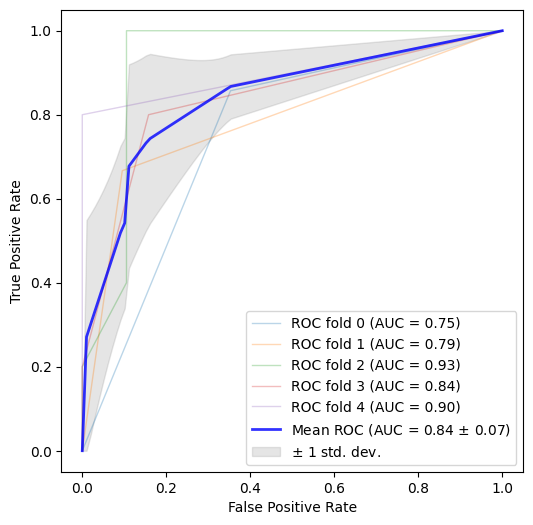

In [46]:
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
kf.get_n_splits(X)

lr_res = []
nn_res = []
svm_res = []
dt_res = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for i, (train_index, test_index) in enumerate(kf.split(X)):

  sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5,9,10,12,13])
  X_train, y_train = sm.fit_resample(X.iloc[train_index], Y.iloc[train_index])
  X_test, y_test = X.iloc[test_index], Y.iloc[test_index]

  print("K-fold split",i,"="*50)
  lr = train_lr(X_train,y_train)
  y_pred = lr.predict(X_test)
  metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
  # print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)
  lr_res.append(metrics1)

  #print("\n\nNEURAL NETWORK "+"="*50)
  mlp = train_nn(X_train,y_train)
  y_pred_proba, y_pred = test_nn(X_test, mlp)
  metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
  # print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)
  nn_res.append(metrics1)


  # print("\n\nSUPPORT VECTOR MACHINE "+"="*50)
  svm = train_svm(X_train,y_train)
  y_pred = svm.predict(X_test)
  metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
  # print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)
  svm_res.append(metrics1)


  print("\n\nDECISION TREE "+"="*50)
  dt = train_dt(X_train,y_train)
  y_pred = dt.predict(X_test)
  y_pred_proba = dt.predict_proba(X_test)
  metrics1, fpr, tpr, auc_val = test_model(y_test, y_pred)
  print("Average acc,ppv,sen,spe,npv,f1,auc:",*metrics1)
  dt_res.append(metrics1)

  viz = RocCurveDisplay.from_predictions(

      y_test,
      y_pred_proba[:,1],
      name=f"ROC fold {i}",
      alpha=0.3,
      lw=1,
      ax=ax,
  )
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)
  print("viz_roc_auc: ", viz.roc_auc)


print("="*100)
print("LOGISTIC REGRESSION"+"="*50)
avg = np.array(lr_res).mean(0)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)

print("\n\nNEURAL NETWORK "+"="*50)
avg = np.array(nn_res).mean(0)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)

print("\n\nSUPPORT VECTOR MACHINE "+"="*50)
avg = np.array(svm_res).mean(0)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)

print("\n\nDECISION TREE "+"="*50)
avg = np.array(dt_res).mean(0)
print("Average acc,ppv,sen,spe,npv,f1,auc:",*avg)
print("="*100)





mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

ax.axis("square")
ax.legend(loc="lower right")
plt.show()